<a href="https://colab.research.google.com/github/javmencia/STA410/blob/main/STA410FP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Proposal:
## Variational Inference for Large-Scale Bayesian Models

### Objective:
This project will explore variational inference (VI) as a scalable alternative to Markov Chain Monte Carlo (MCMC) for fitting Bayesian models. The focus will be on implementing VI for Bayesian regression and comparing its performance to traditional MCMC methods.

### Why This Project?

MCMC can be computationally expensive for high-dimensional models, making VI a valuable alternative.
VI is widely used in machine learning applications, such as deep generative models.
Offers insights into trade-offs between accuracy, speed, and interpretability in Bayesian modeling.
Methods & Implementation:

Implement Bayesian linear regression using both MCMC (e.g., Hamiltonian Monte Carlo) and VI.
Use PyMC or TensorFlow Probability for variational inference.
Compare convergence speed, model fit, and uncertainty quantification.
Extend to more complex models (e.g., Bayesian logistic regression) if time permits

Methods & Implementation
The project will cover the following steps:

1. Implement Bayesian Linear Regression (Baseline Model)

Use PyMC and TensorFlow Probability to implement Bayesian linear regression.
Compare inference results using MCMC (Hamiltonian Monte Carlo) and Variational Inference (ADVI and Mean-Field VI).
Evaluate model performance based on convergence diagnostics, model fit, and uncertainty quantification.
2. Extend to Bayesian Logistic Regression

Implement Bayesian logistic regression using MCMC and VI to handle binary classification problems.
Investigate how inference methods handle classification uncertainty.
3. Explore Hierarchical Bayesian Models

Implement a hierarchical model where parameters share distributions across multiple groups (e.g., multi-level regression).
Compare MCMC vs. VI performance in handling hierarchical structure and information pooling.
4. Introduce Sparsity with Bayesian Regularization

Implement Bayesian Ridge Regression and Sparse Bayesian Learning.
Explore Automatic Relevance Determination (ARD) to shrink unnecessary coefficients to zero.
Compare how MCMC and VI perform in handling sparse priors.
5. Expand to Deep Bayesian Models (Optional Advanced Step)

Apply Bayesian Neural Networks (BNNs) for uncertainty-aware deep learning.
Use Bayesian Dropout and Bayesian Variational Layers to model uncertainty in deep networks.
Compare the computational cost of VI vs. MCMC in deep Bayesian models.
Evaluation Metrics
Inference Speed: Compare runtime performance for MCMC vs. VI.
Convergence Diagnostics: Use Gelman-Rubin statistic and trace plots to check MCMC convergence; assess ELBO (Evidence Lower Bound) for VI.
Prediction Uncertainty: Compare posterior credible intervals.
Model Fit: Use Bayesian R², WAIC, and Bayes Factor to evaluate model performance.
Real-World Applications & Case Studies
Finance: Predicting stock returns with Bayesian regression.
Healthcare: Bayesian modeling of disease risk factors.
Natural Language Processing (NLP): Bayesian topic modeling with Latent Dirichlet Allocation (LDA).

In [1]:
import pymc as pm
import arviz as az
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

## Model set-up

In [2]:
# Bayesian Linear Regression Model
def bayesian_regression_mcmc(X, y, true_beta):
    with pm.Model() as model:
        # Priors
        beta = pm.MvNormal("beta", mu=true_beta, chol=np.eye(X.shape[1]), shape=X.shape[1])
        sigma = pm.HalfCauchy("sigma", beta=2)  # Prior on error term

        # Likelihood
        mu = pm.math.dot(X, beta)
        y_obs = pm.Normal("y_obs", mu=mu, sigma=sigma, observed=y)

        # Sample from the posterior using MCMC
        trace = pm.sample(4000, return_inferencedata=True,
                          idata_kwargs={"log_likelihood": True})  # Ensure log likelihood is stored

    return model, trace

# Bayesian Ridge Regression Model
def bayesian_ridge_regression(X, y, true_beta):
    with pm.Model() as model:
        # Prior on precision (1/tau^2) for ridge penalty
        tau = pm.HalfCauchy("tau", beta=1)  # Shrinkage parameter (larger beta = weaker prior)

        # Ridge prior on beta (similar to L2 regularization)
        beta = pm.MvNormal("beta", mu=true_beta, cov=tau**2 * np.eye(X.shape[1]), shape=X.shape[1])

        # Prior on the noise term
        sigma = pm.HalfCauchy("sigma", beta=2)

        # Likelihood
        mu = pm.math.dot(X, beta)
        y_obs = pm.Normal("y_obs", mu=mu, sigma=sigma, observed=y)

        # Sample from the posterior using MCMC
        trace = pm.sample(4000, return_inferencedata=True,
                          idata_kwargs={"log_likelihood": True})
    return model, trace


# Bayesian Robust Regression Model
def bayesian_robust_regression(X, y, true_beta):
    with pm.Model() as model:
        beta = pm.MvNormal("beta", mu=true_beta, chol=np.eye(X.shape[1]), shape=X.shape[1])
        sigma = pm.HalfCauchy("sigma", beta=2)
        nu = pm.Exponential("nu", 1/30)  # Degrees of freedom for the Student-T

        mu = pm.math.dot(X, beta)
        y_obs = pm.StudentT("y_obs", nu=nu, mu=mu, sigma=sigma, observed=y)

        trace = pm.sample(4000, return_inferencedata=True,
                          idata_kwargs={"log_likelihood": True})

    return model, trace

def bayesian_regression_vi(X, y, true_beta):
    with pm.Model() as model:
        beta = pm.MvNormal("beta", mu=true_beta, chol=np.eye(X.shape[1]), shape=X.shape[1])
        sigma = pm.HalfCauchy("sigma", beta=2)
        mu = pm.math.dot(X, beta)
        y_obs = pm.Normal("y_obs", mu=mu, sigma=sigma, observed=y)
        approx = pm.fit(n=10000, method="advi")  # Automatic Differentiation Variational Inference (ADVI)
    return model, approx.sample(1000)


## Plot models

In [3]:
def run_and_plot_models(X, y, true_beta):
    """
    Runs multiple Bayesian regression models and plots the posterior distributions of beta coefficients.

    Parameters:
        X (array-like): Feature matrix
        y (array-like): Response variable
        true_beta (array-like): True beta coefficients for comparison
    """
    # Run all models
    models = {
        "Bayesian Linear Regression": bayesian_regression_mcmc(X, y, true_beta),
        "Bayesian Ridge Regression": bayesian_ridge_regression(X, y, true_beta),
        "Bayesian Robust Regression": bayesian_robust_regression(X, y, true_beta),
        "Bayesian Variational Inference": bayesian_regression_vi(X, y, true_beta)
    }

    fig, axes = plt.subplots(3, 4, figsize=(18, 12))

    for col, (model_name, (model, trace)) in enumerate(models.items()):
        for i in range(3):  # Assuming 3 beta coefficients
            az.plot_posterior(trace, var_names=["beta"], hdi_prob=0.95, ax=axes[i, col], rope=(-1, 1))
            axes[i, col].set_title(f"{model_name} - beta[{i}]")
            axes[i, col].set_xlim(-1, 1)

    plt.suptitle("Posterior Distributions for All Models", fontsize=16)
    plt.tight_layout()
    plt.subplots_adjust(top=0.85)
    plt.show()


## Changing parameters

In [4]:
def evaluate_model_performance(true_beta, estimated_beta):
    return np.sqrt(np.mean((true_beta - estimated_beta) ** 2))  # RMSE

def run_models_and_evaluate(n=20, p=3, true_beta=None):
    if true_beta is None:
        if p is None:
            raise ValueError("Either true_beta or p must be provided.")
        true_beta = np.logspace(0, 1, p, base=2)  # Generate true_beta based on p

    p = len(true_beta)
    sigma_true = 1

    # Generate data
    X = np.ones((n, p))
    for i in range(0, X.shape[1], 2):
        X[i::2, i] = 0
        X[i+1::2, i] = 1

    y = np.dot(X, true_beta) + stats.norm(0, sigma_true).rvs(n)

    # Run models
    _, trace_mcmc = bayesian_regression_mcmc(X, y, true_beta)
    _, trace_ridge = bayesian_ridge_regression(X, y, true_beta)
    _, trace_robust = bayesian_robust_regression(X, y, true_beta)
    _, trace_vi = bayesian_regression_vi(X, y, true_beta)

    # Extract posterior means
    beta_mcmc = trace_mcmc.posterior['beta'].mean(dim=('chain', 'draw')).values
    beta_ridge = trace_ridge.posterior['beta'].mean(dim=('chain', 'draw')).values
    beta_robust = trace_robust.posterior['beta'].mean(dim=('chain', 'draw')).values
    beta_vi = trace_vi.posterior['beta'].mean(dim=('chain', 'draw')).values

    # Compute RMSE
    rmse_mcmc = evaluate_model_performance(true_beta, beta_mcmc)
    rmse_ridge = evaluate_model_performance(true_beta, beta_ridge)
    rmse_robust = evaluate_model_performance(true_beta, beta_robust)
    rmse_vi = evaluate_model_performance(true_beta, beta_vi)

    return rmse_mcmc, rmse_ridge, rmse_robust, rmse_vi


## Initial set-up

[1.         1.41421356 2.        ]


Output()

Output()

ERROR:pymc.stats.convergence:There were 163 divergences after tuning. Increase `target_accept` or reparameterize.


Output()

Output()

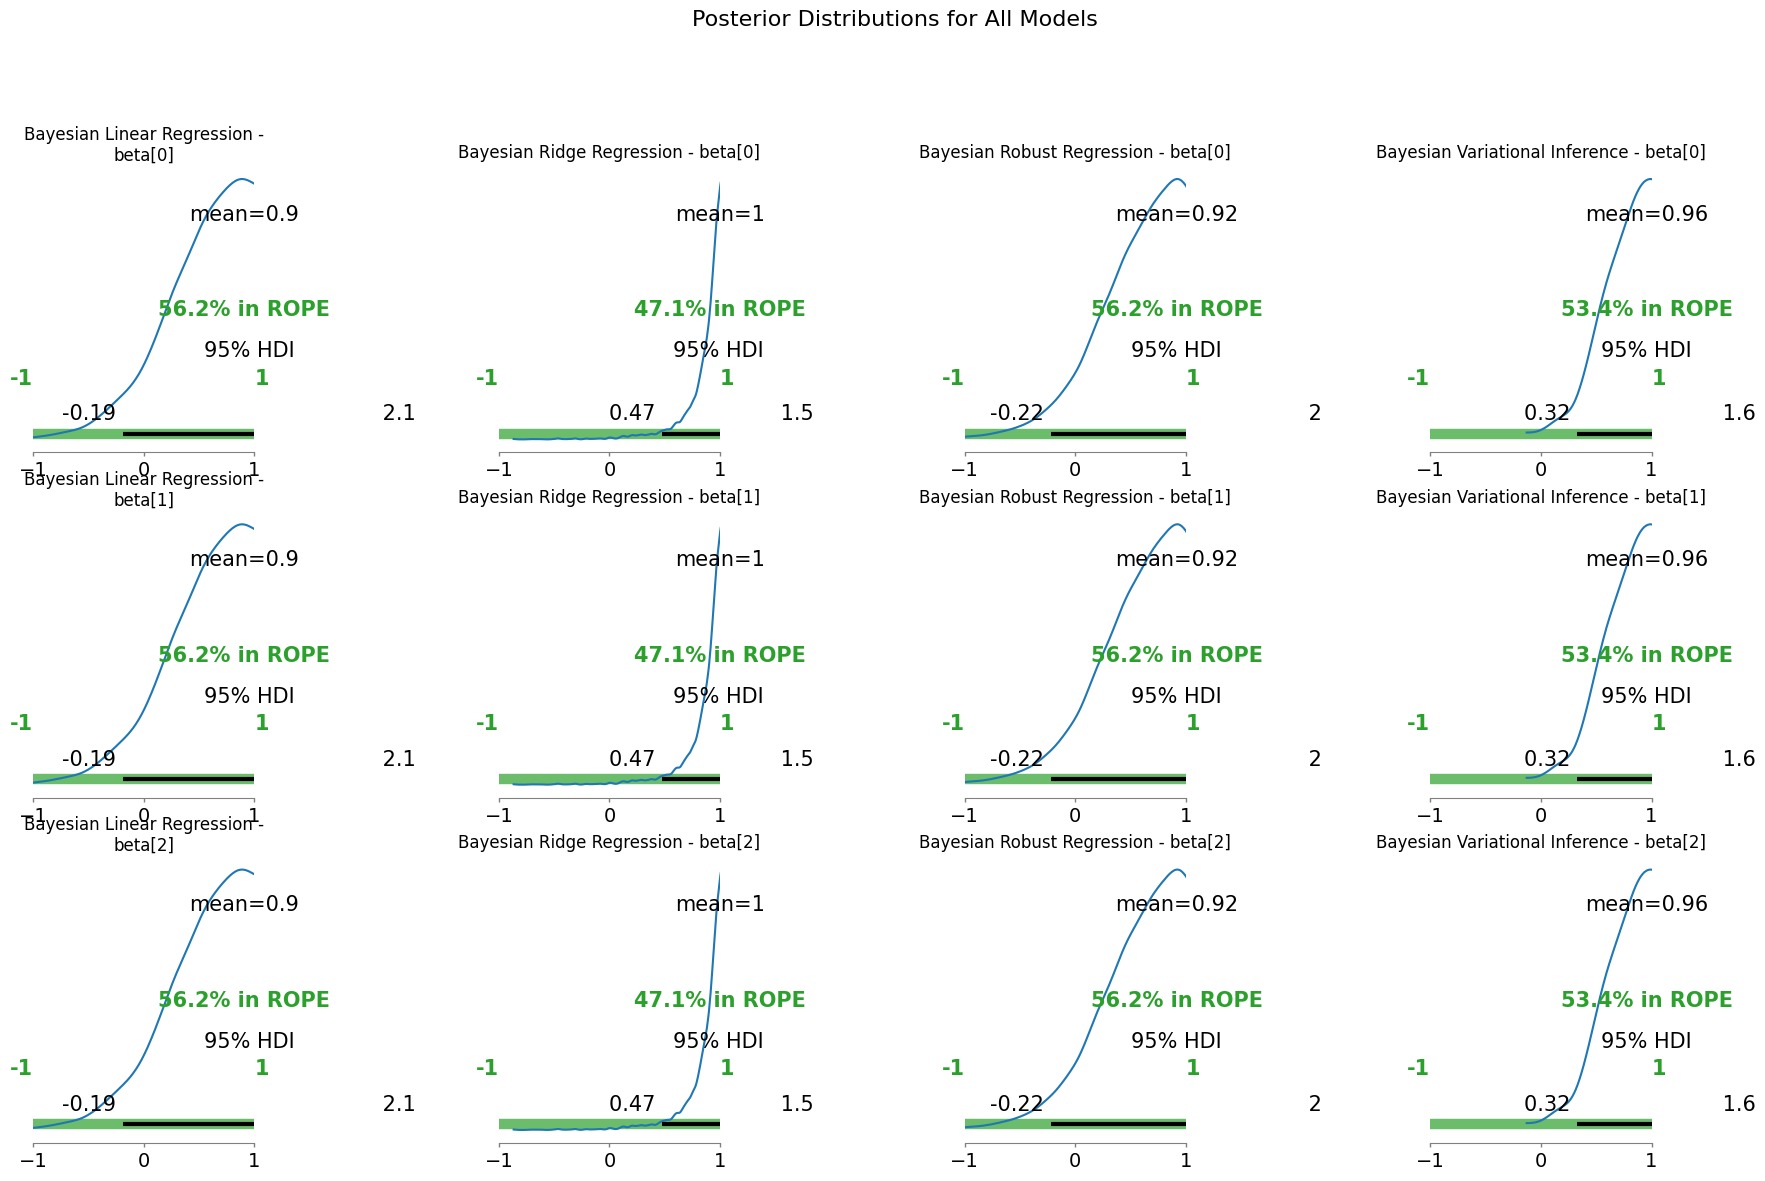

In [5]:
np.random.seed(410)
n=50

# Create alternating columns of [0, 1] and [1, 0] in 3 columns to reduce experimental randomness
X = np.ones((n, 3))
for i in range(0, X.shape[1], 2):
    X[i::2, i] = 0
    X[i+1::2, i] = 1

# Create true_beta based on logspace
true_beta = np.logspace(0, 1, 3, base=2)
sigma_true = 1
print(true_beta)

# Generate y with added random noise
y = np.dot(X, true_beta) + stats.norm(0,sigma_true).rvs(n)

run_and_plot_models(X, y, true_beta)

## Changing the sample size

Running models for sample size: 50


Output()

Output()

ERROR:pymc.stats.convergence:There were 181 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc.stats.convergence:The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


Output()

Output()

Running models for sample size: 100


Output()

ERROR:pymc.stats.convergence:There were 1 divergences after tuning. Increase `target_accept` or reparameterize.


Output()

ERROR:pymc.stats.convergence:There were 215 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc.stats.convergence:The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


Output()

Output()

Running models for sample size: 500


Output()

Output()

ERROR:pymc.stats.convergence:There were 124 divergences after tuning. Increase `target_accept` or reparameterize.


Output()

Output()

Running models for sample size: 1000


Output()

Output()

ERROR:pymc.stats.convergence:There were 144 divergences after tuning. Increase `target_accept` or reparameterize.


Output()

Output()

Running models for sample size: 1500


Output()

Output()

ERROR:pymc.stats.convergence:There were 136 divergences after tuning. Increase `target_accept` or reparameterize.


Output()

Output()

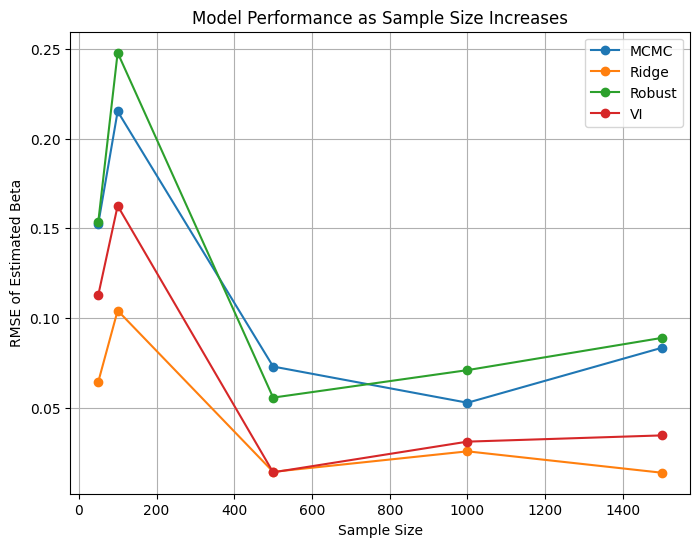

In [6]:
# Define sample sizes to test
sample_sizes = [50, 100, 500, 1000, 1500]
rmse_results = {"MCMC": [], "Ridge": [], "Robust": [], "VI": []}

for n in sample_sizes:
    print(f"Running models for sample size: {n}")
    rmse_mcmc, rmse_ridge, rmse_robust, rmse_vi = run_models_and_evaluate(n)
    rmse_results["MCMC"].append(rmse_mcmc)
    rmse_results["Ridge"].append(rmse_ridge)
    rmse_results["Robust"].append(rmse_robust)
    rmse_results["VI"].append(rmse_vi)

# Plot RMSE as a function of sample size
plt.figure(figsize=(8, 6))
for model, rmse in rmse_results.items():
    plt.plot(sample_sizes, rmse, marker='o', label=model)
plt.xlabel("Sample Size")
plt.ylabel("RMSE of Estimated Beta")
plt.title("Model Performance as Sample Size Increases")
plt.legend()
plt.grid()
plt.show()

## Changing the number of parameters

Running models for this many parameters: 5
[1.         1.18920712 1.41421356 1.68179283 2.        ]
[[0. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1.]
 [0. 1. 0. 1. 1.]
 [1. 1. 1. 1. 1.]
 [0. 1. 0. 1. 0.]
 [1. 1. 1. 1. 1.]
 [0. 1. 0. 1. 0.]
 [1. 1. 1. 1. 1.]
 [0. 1. 0. 1. 0.]
 [1. 1. 1. 1. 1.]
 [0. 1. 0. 1. 0.]
 [1. 1. 1. 1. 1.]
 [0. 1. 0. 1. 0.]
 [1. 1. 1. 1. 1.]
 [0. 1. 0. 1. 0.]
 [1. 1. 1. 1. 1.]
 [0. 1. 0. 1. 0.]
 [1. 1. 1. 1. 1.]
 [0. 1. 0. 1. 0.]
 [1. 1. 1. 1. 1.]]
[6.34313041 8.23862283 3.40327589 6.55677829 2.70763078 7.86717578
 2.55954932 6.91704153 3.04405375 7.51581882 0.98431795 6.06781911
 2.29043936 7.84471689 2.60464811 7.64656651 2.56546417 8.03525878
 4.57115549 6.11193809]


Output()

ERROR:pymc.stats.convergence:There were 1 divergences after tuning. Increase `target_accept` or reparameterize.


Output()

ERROR:pymc.stats.convergence:There were 21 divergences after tuning. Increase `target_accept` or reparameterize.


Output()

Output()

Running models for this many parameters: 10
[1.         1.08005974 1.16652904 1.25992105 1.36079    1.46973449
 1.58740105 1.71448797 1.85174942 2.        ]
[[0. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [0. 1. 0. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [0. 1. 0. 1. 0. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [0. 1. 0. 1. 0. 1. 0. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [0. 1. 0. 1. 0. 1. 0. 1. 0. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [0. 1. 0. 1. 0. 1. 0. 1. 0. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [0. 1. 0. 1. 0. 1. 0. 1. 0. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [0. 1. 0. 1. 0. 1. 0. 1. 0. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [0. 1. 0. 1. 0. 1. 0. 1. 0. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [0. 1. 0. 1. 0. 1. 0. 1. 0. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]]
[14.17123287 13.45095174 11.80316809 13.9593039   9.36397084 12.84057616
 10.05979643 13.91879166  5.86469927 14.33416863  6.37577213 14.257566
  6.51794212 15.60022719  7.40053405 1

Output()

ERROR:pymc.stats.convergence:There were 33 divergences after tuning. Increase `target_accept` or reparameterize.


Output()

ERROR:pymc.stats.convergence:There were 4 divergences after tuning. Increase `target_accept` or reparameterize.


Output()

Output()

Running models for this many parameters: 15
[1.         1.05075664 1.10408951 1.16012939 1.21901365 1.28088669
 1.34590019 1.41421356 1.48599429 1.56141836 1.64067071 1.72394564
 1.81144733 1.90339031 2.        ]
[[0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [0. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [0. 1. 0. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [0. 1. 0. 1. 0. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [0. 1. 0. 1. 0. 1.

Output()

ERROR:pymc.stats.convergence:There were 26 divergences after tuning. Increase `target_accept` or reparameterize.


Output()

ERROR:pymc.stats.convergence:There were 1 divergences after tuning. Increase `target_accept` or reparameterize.


Output()

Output()

Running models for this many parameters: 20
[1.         1.03715504 1.07569059 1.11565792 1.15711024 1.20010272
 1.24469259 1.2909392  1.3389041  1.38865114 1.44024654 1.49375896
 1.54925964 1.60682245 1.66652401 1.72844379 1.79266419 1.85927071
 1.928352   2.        ]
[[0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [0. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [0. 1. 0. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [0. 1. 0. 1. 0. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 

Output()

ERROR:pymc.stats.convergence:There were 46 divergences after tuning. Increase `target_accept` or reparameterize.


Output()

ERROR:pymc.stats.convergence:There were 8 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc.stats.convergence:The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


Output()

Output()

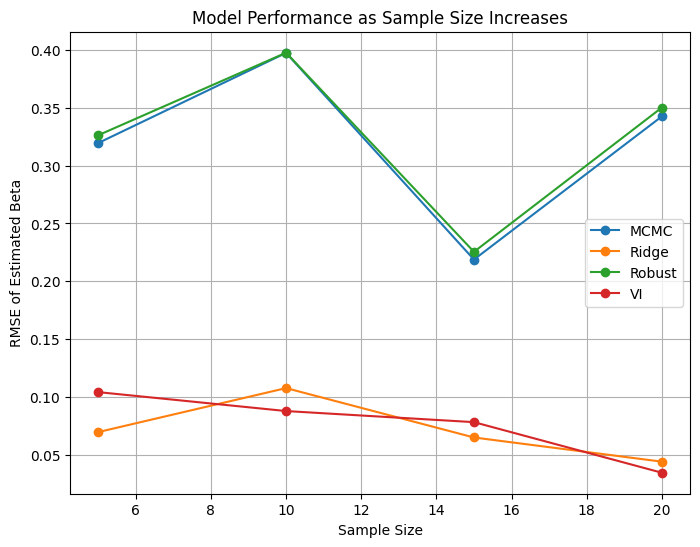

In [7]:
# Define sample sizes to test
p_numbers = [5, 10, 15, 20]
n=20
rmse_results = {"MCMC": [], "Ridge": [], "Robust": [], "VI": []}

for p in p_numbers:
    print(f"Running models for this many parameters: {p}")
    rmse_mcmc, rmse_ridge, rmse_robust, rmse_vi = run_models_and_evaluate(p)
    rmse_results["MCMC"].append(rmse_mcmc)
    rmse_results["Ridge"].append(rmse_ridge)
    rmse_results["Robust"].append(rmse_robust)
    rmse_results["VI"].append(rmse_vi)

# Plot RMSE as a function of sample size
plt.figure(figsize=(8, 6))
for model, rmse in rmse_results.items():
    plt.plot(p_numbers, rmse, marker='o', label=model)
plt.xlabel("Number of Predictors")
plt.ylabel("RMSE of Estimated Beta")
plt.title("Model Performance as Number of Predictors Increases")
plt.legend()
plt.grid()
plt.show()

## Changing magnitudes

Running models with true_beta: [1, 1, 2]


Output()

Output()

ERROR:pymc.stats.convergence:There were 235 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc.stats.convergence:The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


Output()

Output()

Running models with true_beta: [1, 1.4142135623730951, 2]


Output()

Output()

ERROR:pymc.stats.convergence:There were 148 divergences after tuning. Increase `target_accept` or reparameterize.


Output()

Output()

Running models with true_beta: [1, 4, 2]


Output()

Output()

ERROR:pymc.stats.convergence:There were 557 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc.stats.convergence:The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


Output()

Output()

Running models with true_beta: [1, 8, 2]


Output()

Output()

ERROR:pymc.stats.convergence:There were 54 divergences after tuning. Increase `target_accept` or reparameterize.


Output()

Output()

Running models with true_beta: [1, 16, 2]


Output()

Output()

ERROR:pymc.stats.convergence:There were 420 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc.stats.convergence:The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


Output()

Output()

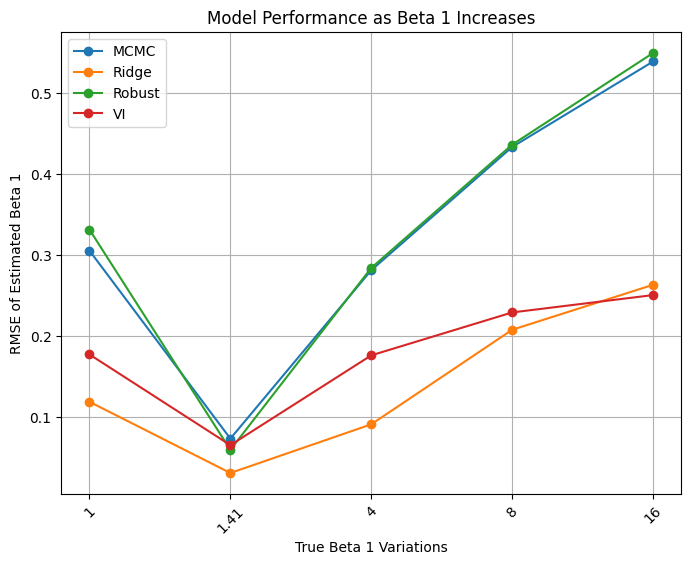

In [9]:
# Define different values where only one coefficient increases at a time
beta_variations = [
    [1, 1, 2],
    [1, float(np.sqrt(2)), 2],
    [1, 4, 2],
    [1, 8, 2],
    [1, 16, 2]
]

n = 20
rmse_results = {"MCMC": [], "Ridge": [], "Robust": [], "VI": []}

for true_beta in beta_variations:
    print(f"Running models with true_beta: {true_beta}")
    rmse_mcmc, rmse_ridge, rmse_robust, rmse_vi = run_models_and_evaluate(n = n, true_beta = true_beta)
    rmse_results["MCMC"].append(rmse_mcmc)
    rmse_results["Ridge"].append(rmse_ridge)
    rmse_results["Robust"].append(rmse_robust)
    rmse_results["VI"].append(rmse_vi)

# Plot RMSE as a function of increasing individual beta values
plt.figure(figsize=(8, 6))
beta_labels = [
    "1", "1.41", "4", "8", "16"
]
for model, rmse in rmse_results.items():
    plt.plot(beta_labels, rmse, marker='o', label=model)
plt.xlabel("True Beta 1 Variations")
plt.ylabel("RMSE of Estimated Beta 1")
plt.title("Model Performance as Beta 1 Increases")
plt.xticks(rotation=45)
plt.legend()
plt.grid()
plt.show()


Running models with true_beta: [1, 1.4142135623730951, 2]


Output()

Output()

ERROR:pymc.stats.convergence:There were 186 divergences after tuning. Increase `target_accept` or reparameterize.


Output()

Output()

Running models with true_beta: [2, 1.4142135623730951, 2]


Output()

Output()

ERROR:pymc.stats.convergence:There were 391 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc.stats.convergence:The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


Output()

Output()

Running models with true_beta: [4, 1.4142135623730951, 2]


Output()

Output()

ERROR:pymc.stats.convergence:There were 113 divergences after tuning. Increase `target_accept` or reparameterize.


Output()

Output()

Running models with true_beta: [8, 1.4142135623730951, 2]


Output()

Output()

ERROR:pymc.stats.convergence:There were 206 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc.stats.convergence:The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


Output()

Output()

Running models with true_beta: [32, 1.4142135623730951, 2]


Output()

Output()

ERROR:pymc.stats.convergence:There were 23 divergences after tuning. Increase `target_accept` or reparameterize.


Output()

Output()

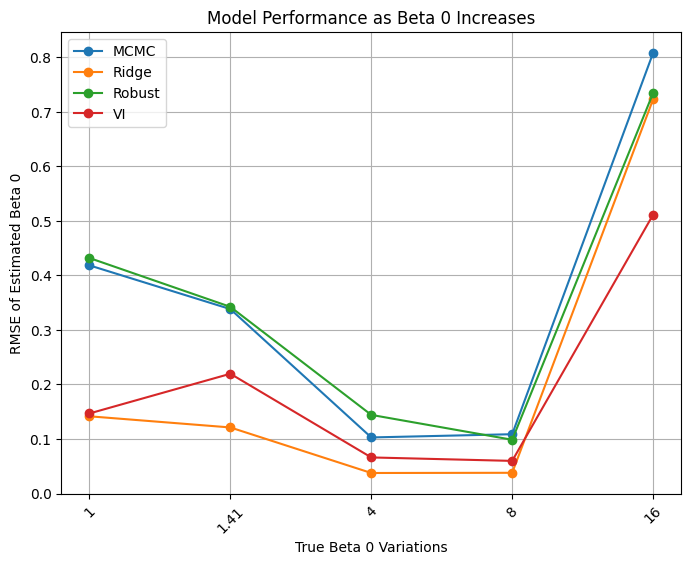

In [10]:
# Define different values where only one coefficient increases at a time
beta_variations = [
    [1, float(np.sqrt(2)), 2],
    [2, float(np.sqrt(2)), 2],
    [4, float(np.sqrt(2)), 2],
    [8, float(np.sqrt(2)), 2],
    [32, float(np.sqrt(2)), 2]
]

n = 20
rmse_results = {"MCMC": [], "Ridge": [], "Robust": [], "VI": []}

for true_beta in beta_variations:
    print(f"Running models with true_beta: {true_beta}")
    rmse_mcmc, rmse_ridge, rmse_robust, rmse_vi = run_models_and_evaluate(n = n, true_beta = true_beta)
    rmse_results["MCMC"].append(rmse_mcmc)
    rmse_results["Ridge"].append(rmse_ridge)
    rmse_results["Robust"].append(rmse_robust)
    rmse_results["VI"].append(rmse_vi)

# Plot RMSE as a function of increasing individual beta values
plt.figure(figsize=(8, 6))
beta_labels = [
    "1", "1.41", "4", "8", "16"
]
for model, rmse in rmse_results.items():
    plt.plot(beta_labels, rmse, marker='o', label=model)
plt.xlabel("True Beta 0 Variations")
plt.ylabel("RMSE of Estimated Beta 0")
plt.title("Model Performance as Beta 0 Increases")
plt.xticks(rotation=45)
plt.legend()
plt.grid()
plt.show()


### Other

Output()

Output()

ERROR:pymc.stats.convergence:There were 92 divergences after tuning. Increase `target_accept` or reparameterize.


Output()

Output()

Output()

Output()

ERROR:pymc.stats.convergence:There were 242 divergences after tuning. Increase `target_accept` or reparameterize.


Output()

Output()

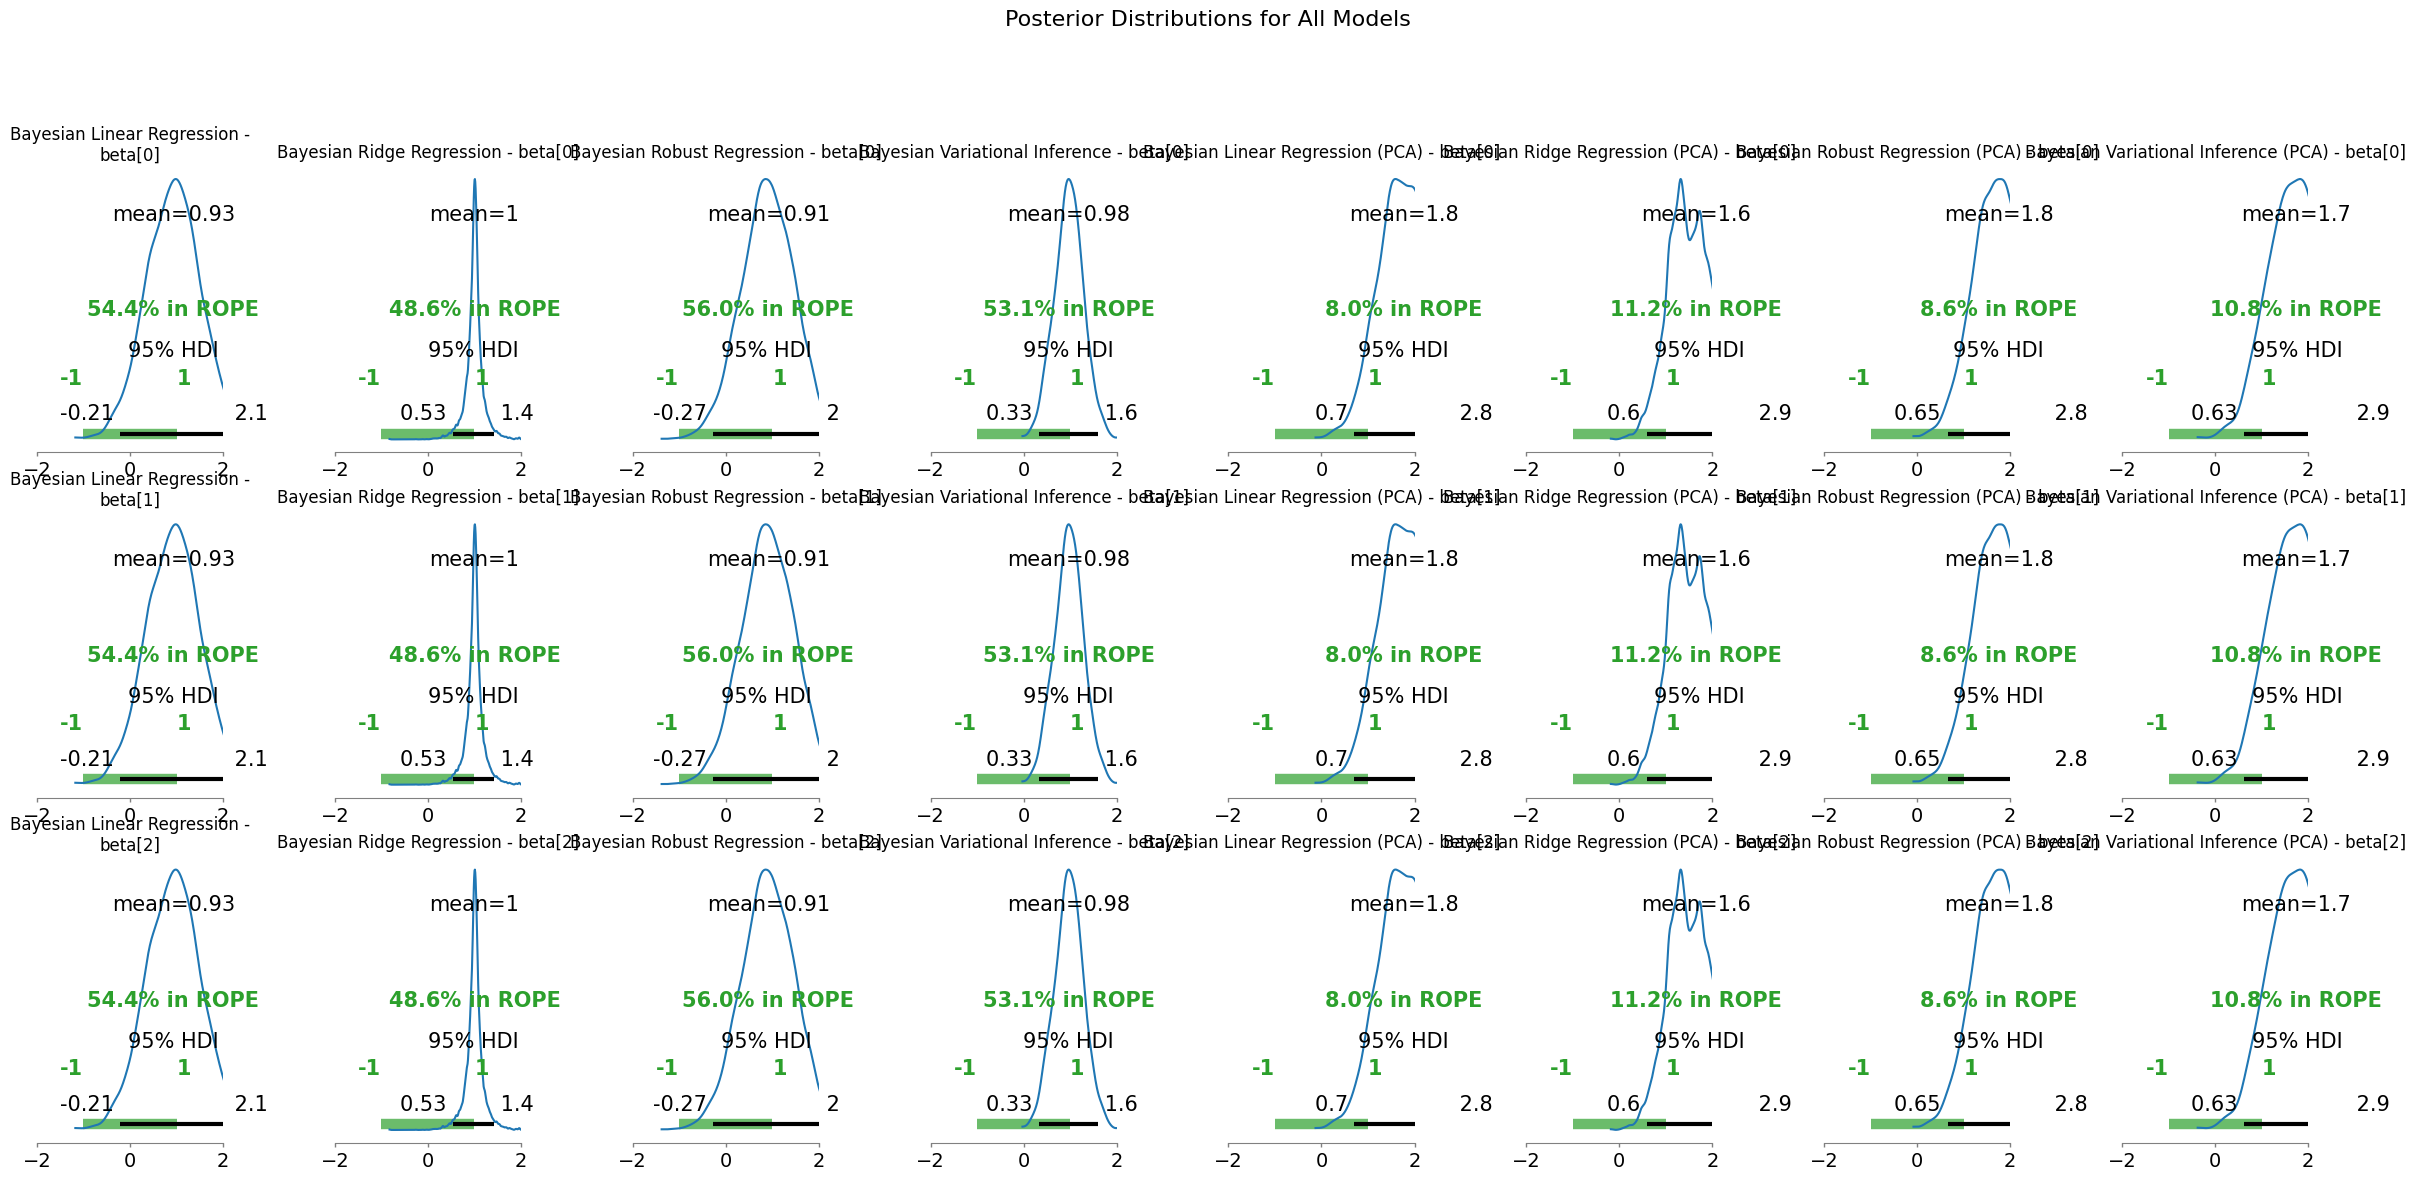

In [12]:
import numpy as np
import pymc as pm
import scipy.stats as stats
import arviz as az
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Function to apply PCA and transform X
def apply_pca(X, n_components=None):
    pca = PCA(n_components=n_components)
    X_transformed = pca.fit_transform(X)
    return X_transformed, pca

# General Bayesian Regression Model
def bayesian_regression_mcmc(X, y, true_beta, use_pca=False):
    if use_pca:
        X, pca = apply_pca(X)
    else:
        pca = None

    with pm.Model() as model:
        beta = pm.MvNormal("beta", mu=true_beta[:X.shape[1]], chol=np.eye(X.shape[1]), shape=X.shape[1])
        sigma = pm.HalfCauchy("sigma", beta=2)
        mu = pm.math.dot(X, beta)
        y_obs = pm.Normal("y_obs", mu=mu, sigma=sigma, observed=y)
        trace = pm.sample(4000, return_inferencedata=True, idata_kwargs={"log_likelihood": True})

    return model, trace, pca

# General Bayesian Ridge Regression Model
def bayesian_ridge_regression(X, y, true_beta, use_pca=False):
    if use_pca:
        X, pca = apply_pca(X)
    else:
        pca = None

    with pm.Model() as model:
        tau = pm.HalfCauchy("tau", beta=1)
        beta = pm.MvNormal("beta", mu=true_beta[:X.shape[1]], cov=tau**2 * np.eye(X.shape[1]), shape=X.shape[1])
        sigma = pm.HalfCauchy("sigma", beta=2)
        mu = pm.math.dot(X, beta)
        y_obs = pm.Normal("y_obs", mu=mu, sigma=sigma, observed=y)
        trace = pm.sample(4000, return_inferencedata=True, idata_kwargs={"log_likelihood": True})

    return model, trace, pca

# General Bayesian Robust Regression Model
def bayesian_robust_regression(X, y, true_beta, use_pca=False):
    if use_pca:
        X, pca = apply_pca(X)
    else:
        pca = None

    with pm.Model() as model:
        beta = pm.MvNormal("beta", mu=true_beta[:X.shape[1]], chol=np.eye(X.shape[1]), shape=X.shape[1])
        sigma = pm.HalfCauchy("sigma", beta=2)
        nu = pm.Exponential("nu", 1/30)
        mu = pm.math.dot(X, beta)
        y_obs = pm.StudentT("y_obs", nu=nu, mu=mu, sigma=sigma, observed=y)
        trace = pm.sample(4000, return_inferencedata=True, idata_kwargs={"log_likelihood": True})

    return model, trace, pca

# General Bayesian Regression with Variational Inference (VI)
def bayesian_regression_vi(X, y, true_beta, use_pca=False):
    if use_pca:
        X, pca = apply_pca(X)
    else:
        pca = None

    with pm.Model() as model:
        beta = pm.MvNormal("beta", mu=true_beta[:X.shape[1]], chol=np.eye(X.shape[1]), shape=X.shape[1])
        sigma = pm.HalfCauchy("sigma", beta=2)
        mu = pm.math.dot(X, beta)
        y_obs = pm.Normal("y_obs", mu=mu, sigma=sigma, observed=y)
        approx = pm.fit(n=10000, method="advi")

    return model, approx.sample(1000), pca

# Function to run models and plot posterior distributions
def run_and_plot_models(X, y, true_beta):
    models = {
        "Bayesian Linear Regression": bayesian_regression_mcmc(X, y, true_beta, use_pca=False),
        "Bayesian Ridge Regression": bayesian_ridge_regression(X, y, true_beta, use_pca=False),
        "Bayesian Robust Regression": bayesian_robust_regression(X, y, true_beta, use_pca=False),
        "Bayesian Variational Inference": bayesian_regression_vi(X, y, true_beta, use_pca=False),
        "Bayesian Linear Regression (PCA)": bayesian_regression_mcmc(X, y, true_beta, use_pca=True),
        "Bayesian Ridge Regression (PCA)": bayesian_ridge_regression(X, y, true_beta, use_pca=True),
        "Bayesian Robust Regression (PCA)": bayesian_robust_regression(X, y, true_beta, use_pca=True),
        "Bayesian Variational Inference (PCA)": bayesian_regression_vi(X, y, true_beta, use_pca=True)
    }

    fig, axes = plt.subplots(3, 8, figsize=(24, 12))

    for col, (model_name, (model, trace, _)) in enumerate(models.items()):
        for i in range(3):
            az.plot_posterior(trace, var_names=["beta"], hdi_prob=0.95, ax=axes[i, col], rope=(-1, 1))
            axes[i, col].set_title(f"{model_name} - beta[{i}]")
            axes[i, col].set_xlim(-2, 2)

    plt.suptitle("Posterior Distributions for All Models", fontsize=16)
    plt.tight_layout()
    plt.subplots_adjust(top=0.85)
    plt.show()

np.random.seed(410)
n = 50
X = np.ones((n, 3))
for i in range(0, X.shape[1], 2):
    X[i::2, i] = 0
    X[i+1::2, i] = 1

true_beta = np.logspace(0, 1, 3, base=2)
sigma_true = 1
y = np.dot(X, true_beta) + stats.norm(0, sigma_true).rvs(n)

run_and_plot_models(X, y, true_beta)


In [ ]:
from sklearn.decomposition import PCA
import pymc as pm
import numpy as np
import arviz as az
import matplotlib.pyplot as plt
from scipy import stats

def bayesian_pcr(X, y, true_beta, n_components=None):
    """
    Bayesian Principal Component Regression (PCR)
    """
    pca = PCA(n_components=n_components)
    X_pca = pca.fit_transform(X)  # Transform X to principal components

    with pm.Model() as model:
        # Prior on beta coefficients for PCA components
        beta = pm.MvNormal("beta", mu=true_beta[:X_pca.shape[1]],
                           chol=np.eye(X_pca.shape[1]),
                           shape=X_pca.shape[1])

        sigma = pm.HalfCauchy("sigma", beta=2)  # Prior on error term

        # Likelihood
        mu = pm.math.dot(X_pca, beta)
        y_obs = pm.Normal("y_obs", mu=mu, sigma=sigma, observed=y)

        # MCMC sampling
        trace = pm.sample(4000, return_inferencedata=True,
                          idata_kwargs={"log_likelihood": True})

    return model, trace, pca

def run_and_plot_models(X, y, true_beta):
    """
    Runs multiple Bayesian regression models and plots the posterior distributions of beta coefficients.
    """
    models = {
        "Bayesian Linear Regression": bayesian_regression_mcmc(X, y, true_beta),
        "Bayesian Ridge Regression": bayesian_ridge_regression(X, y, true_beta),
        "Bayesian Robust Regression": bayesian_robust_regression(X, y, true_beta),
        "Bayesian Variational Inference": bayesian_regression_vi(X, y, true_beta),
        "Bayesian Principal Component Regression": bayesian_pcr(X, y, true_beta, n_components=2)
    }

    fig, axes = plt.subplots(3, 5, figsize=(20, 12))

    for col, (model_name, (model, trace)) in enumerate(models.items()):
        for i in range(3):  # Assuming 3 beta coefficients
            az.plot_posterior(trace, var_names=["beta"], hdi_prob=0.95, ax=axes[i, col], rope=(-1, 1))
            axes[i, col].set_title(f"{model_name} - beta[{i}]")
            axes[i, col].set_xlim(-1, 1)

    plt.suptitle("Posterior Distributions for All Models", fontsize=16)
    plt.tight_layout()
    plt.subplots_adjust(top=0.85)
    plt.show()

np.random.seed(410)
n = 50
X = np.ones((n, 3))
for i in range(0, X.shape[1], 2):
    X[i::2, i] = 0
    X[i+1::2, i] = 1
true_beta = np.logspace(0, 1, 3, base=2)
sigma_true = 1
y = np.dot(X, true_beta) + stats.norm(0, sigma_true).rvs(n)

run_and_plot_models(X, y, true_beta)

Output()

Output()

Output()

Output()

Output()

Output()

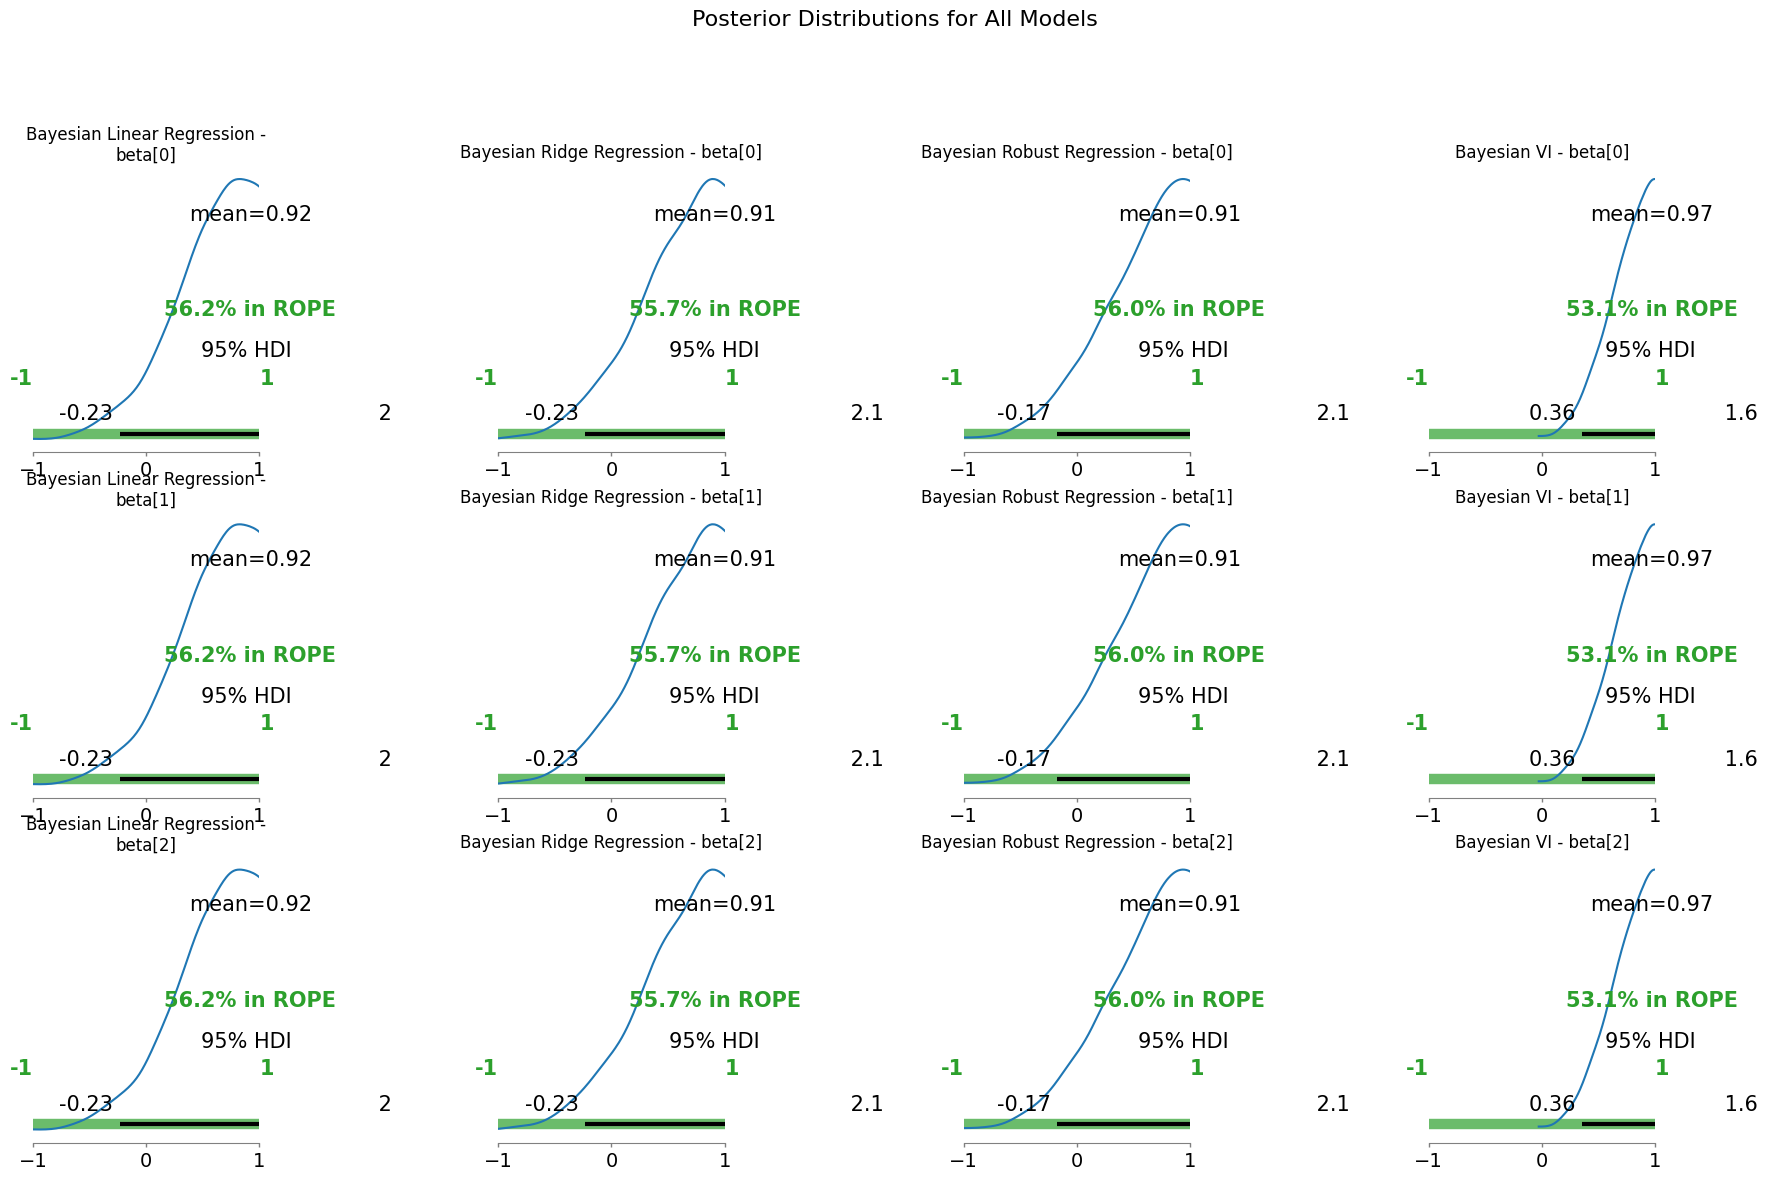

In [ ]:
import pymc as pm
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import arviz as az

# Bayesian Linear Regression Model
def bayesian_regression_mcmc(X, y):
    with pm.Model() as model:
        beta = pm.MvNormal("beta", mu=true_beta, cov=np.eye(3), shape=(3,))
        sigma = pm.HalfCauchy("sigma", beta=2)

        mu = pm.math.dot(X, beta[:, None]).flatten()  # Ensure correct shape
        y_obs = pm.Normal("y_obs", mu=mu, sigma=sigma, observed=y)

        trace = pm.sample(2000, return_inferencedata=True, target_accept=0.95,
                          idata_kwargs={"log_likelihood": True})

    return model, trace

# Bayesian Ridge Regression Model
def bayesian_ridge_regression(X, y):
    with pm.Model() as model:
        beta = pm.MvNormal("beta", mu=true_beta, cov=np.eye(3), shape=(3,))
        sigma = pm.HalfCauchy("sigma", beta=2)

        mu = pm.math.dot(X, beta[:, None]).flatten()
        y_obs = pm.Normal("y_obs", mu=mu, sigma=sigma, observed=y)

        trace = pm.sample(2000, return_inferencedata=True, target_accept=0.95,
                          idata_kwargs={"log_likelihood": True})

    return model, trace

# Bayesian Robust Regression Model
def bayesian_robust_regression(X, y):
    with pm.Model() as model:
        beta = pm.MvNormal("beta", mu=true_beta, cov=np.eye(3), shape=(3,))
        sigma = pm.HalfCauchy("sigma", beta=2)
        nu = pm.Exponential("nu", 1/30)

        mu = pm.math.dot(X, beta[:, None]).flatten()
        y_obs = pm.StudentT("y_obs", nu=nu, mu=mu, sigma=sigma, observed=y)

        trace = pm.sample(2000, return_inferencedata=True, target_accept=0.95,
                          idata_kwargs={"log_likelihood": True})

    return model, trace

# Bayesian Variational Inference Model
def bayesian_regression_vi(X, y):
    with pm.Model() as model:
        beta = pm.MvNormal("beta", mu=true_beta, cov=np.eye(3), shape=(3,))
        sigma = pm.HalfCauchy("sigma", beta=2)

        mu = pm.math.dot(X, beta[:, None]).flatten()
        y_obs = pm.Normal("y_obs", mu=mu, sigma=sigma, observed=y)

        approx = pm.fit(n=10000, method="advi")

    return model, approx.sample(1000)

# Generate Data
np.random.seed(410)
n = 50
X = np.ones((n, 3))
for i in range(0, X.shape[1], 2):
    X[i::2, i] = 0
    X[i+1::2, i] = 1

true_beta = np.logspace(0, 1, 3, base=2)
sigma_true = 1
y = np.dot(X, true_beta) + stats.norm(0, sigma_true).rvs(n)

# Run Models
model_mcmc, trace_mcmc = bayesian_regression_mcmc(X, y)
model_ridge, trace_ridge = bayesian_ridge_regression(X, y)
model_robust, trace_robust = bayesian_robust_regression(X, y)
model_vi, trace_vi = bayesian_regression_vi(X, y)

# Plot Results
fig, axes = plt.subplots(3, 4, figsize=(18, 12))

# Plot Posterior Distributions
models = [trace_mcmc, trace_ridge, trace_robust, trace_vi]
titles = ["Bayesian Linear Regression", "Bayesian Ridge Regression", "Bayesian Robust Regression", "Bayesian VI"]

for j, trace in enumerate(models):
    for i in range(3):
        az.plot_posterior(trace, var_names=["beta"], hdi_prob=0.95, ax=axes[i, j], rope=(-1, 1))
        axes[i, j].set_title(f"{titles[j]} - beta[{i}]")
        axes[i, j].set_xlim(-1, 1)

plt.suptitle("Posterior Distributions for All Models", fontsize=16)
plt.tight_layout()
plt.subplots_adjust(top=0.85)
plt.show()


True beta coefficients: [1.         1.41421356 2.        ]


Output()

Output()

Output()

ERROR:pymc.stats.convergence:There were 107 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc.stats.convergence:The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


Output()

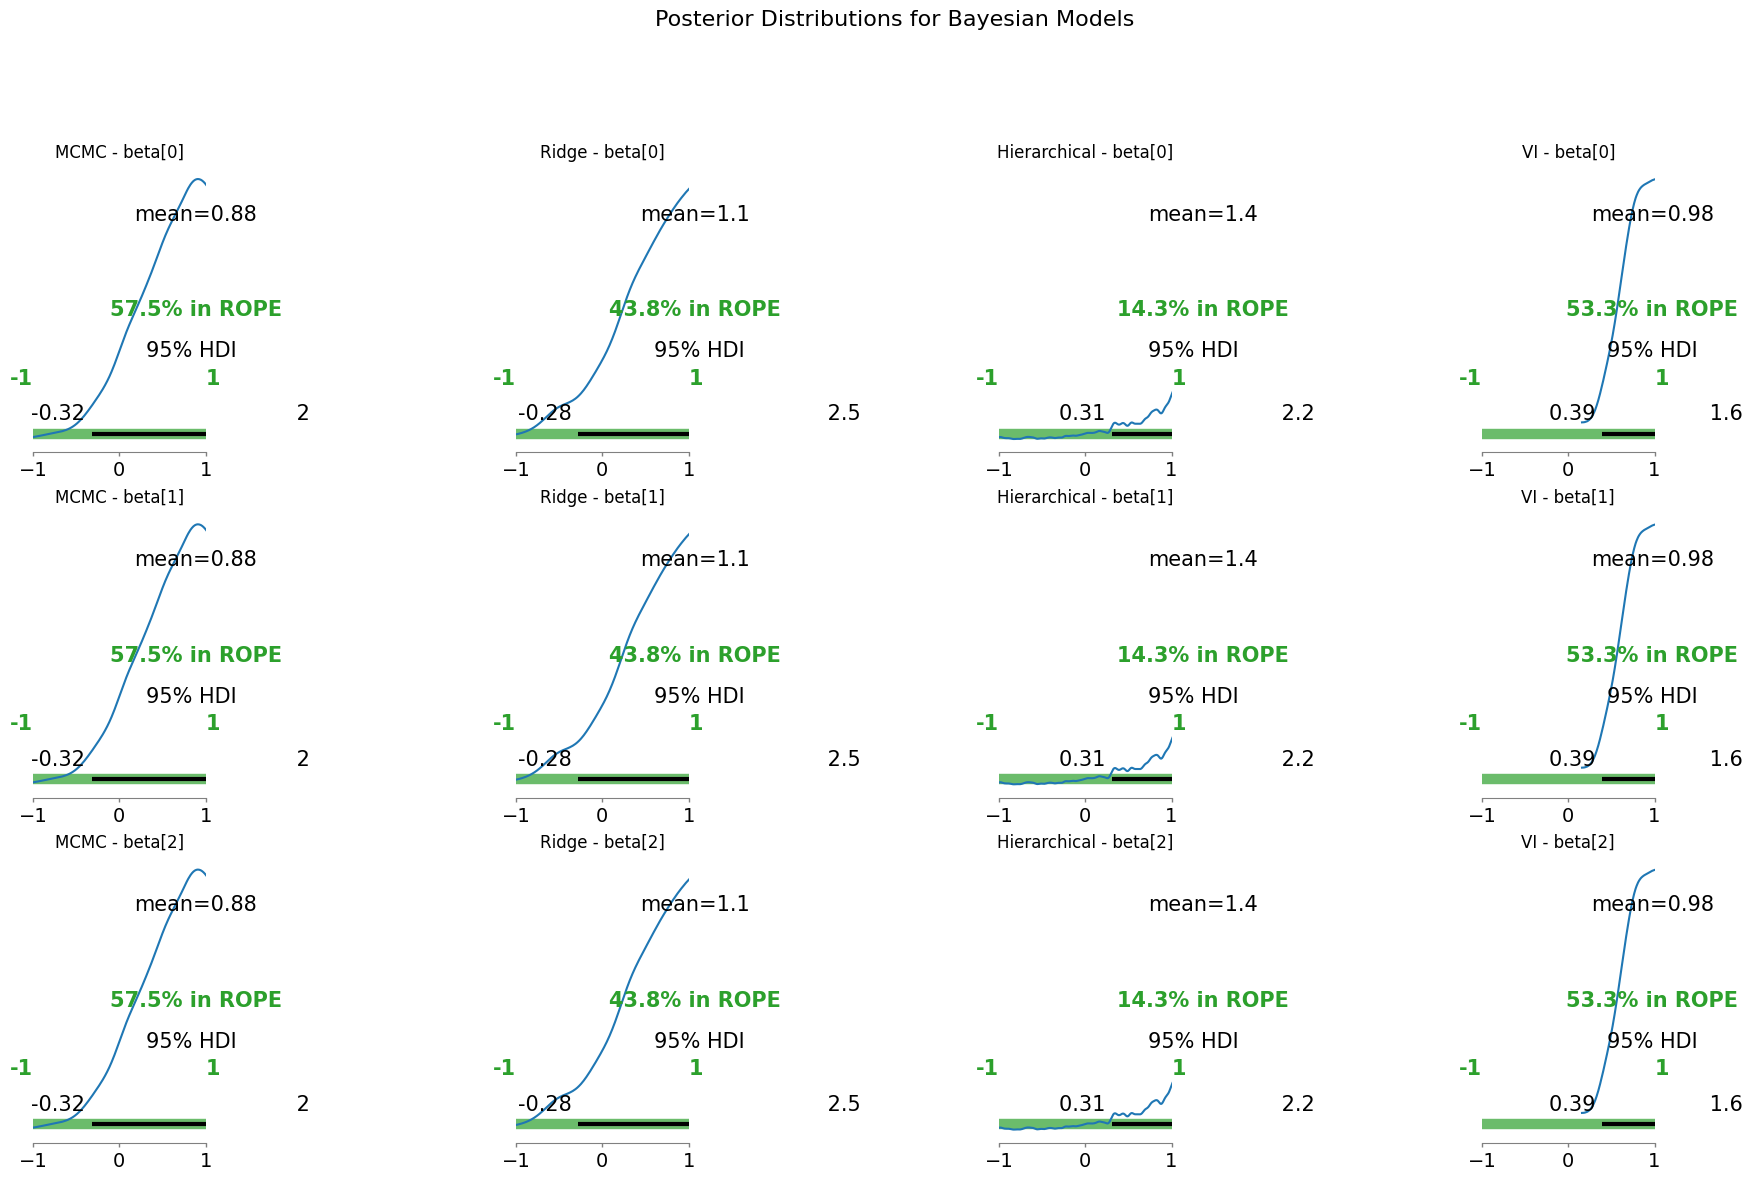

In [12]:
import numpy as np
import pymc as pm
import arviz as az
import matplotlib.pyplot as plt
from scipy import stats

# Set seed for reproducibility
np.random.seed(410)
n = 50

# Create design matrix X with structured alternation
X = np.ones((n, 3))
for i in range(0, X.shape[1], 2):
    X[i::2, i] = 0
    X[i+1::2, i] = 1

# Define true beta coefficients using logspace
true_beta = np.logspace(0, 1, 3, base=2)
sigma_true = 1
print("True beta coefficients:", true_beta)

# Generate response variable y with added noise
y = np.dot(X, true_beta) + stats.norm(0, sigma_true).rvs(n)

# Function for Bayesian Linear Regression using MCMC
def bayesian_regression_mcmc(X, y):
    with pm.Model() as model:
        beta = pm.MvNormal("beta", mu=true_beta, chol=np.eye(3), shape=3)
        sigma = pm.HalfCauchy("sigma", beta=2)
        mu = pm.math.dot(X, beta)
        y_obs = pm.Normal("y_obs", mu=mu, sigma=sigma, observed=y)
        trace = pm.sample(2000, return_inferencedata=True, target_accept=0.95,
                          idata_kwargs={"log_likelihood": True})
    return model, trace

# Function for Bayesian Ridge Regression
def bayesian_ridge_regression(X, y):
    with pm.Model() as model:
        lambda_ = pm.Gamma("lambda", alpha=1.0, beta=1.0)
        beta = pm.Normal("beta", mu=0, sigma=1 / pm.math.sqrt(lambda_), shape=3)
        sigma = pm.HalfCauchy("sigma", beta=2)
        mu = pm.math.dot(X, beta)
        y_obs = pm.Normal("y_obs", mu=mu, sigma=sigma, observed=y)
        trace = pm.sample(2000, return_inferencedata=True, target_accept=0.95)
    return model, trace

# Function for Hierarchical Bayesian Regression
def hierarchical_bayesian_regression(X, y):
    with pm.Model() as model:
        group_mu = pm.Normal("group_mu", mu=0, sigma=2)
        group_sigma = pm.HalfCauchy("group_sigma", beta=2)
        beta = pm.Normal("beta", mu=group_mu, sigma=group_sigma, shape=3)
        sigma = pm.HalfCauchy("sigma", beta=2)
        mu = pm.math.dot(X, beta)
        y_obs = pm.Normal("y_obs", mu=mu, sigma=sigma, observed=y)
        trace = pm.sample(2000, return_inferencedata=True, target_accept=0.95)
    return model, trace

# Function for Bayesian Linear Regression using Variational Inference
def bayesian_regression_vi(X, y):
    with pm.Model() as model:
        beta = pm.MvNormal("beta", mu=true_beta, chol=np.eye(3), shape=3)
        sigma = pm.HalfCauchy("sigma", beta=2)
        mu = pm.math.dot(X, beta)
        y_obs = pm.Normal("y_obs", mu=mu, sigma=sigma, observed=y)
        approx = pm.fit(n=10000, method="advi")
    return model, approx.sample(1000)

# Run models
model_mcmc, trace_mcmc = bayesian_regression_mcmc(X, y)
model_ridge, trace_ridge = bayesian_ridge_regression(X, y)
model_hierarchical, trace_hierarchical = hierarchical_bayesian_regression(X, y)
model_vi, trace_vi = bayesian_regression_vi(X, y)

# Create posterior plots
fig, axes = plt.subplots(3, 4, figsize=(18, 12))
models = [trace_mcmc, trace_ridge, trace_hierarchical, trace_vi]
model_titles = ["MCMC", "Ridge", "Hierarchical", "VI"]

for col, (trace, title) in enumerate(zip(models, model_titles)):
    for i in range(3):
        az.plot_posterior(trace, var_names=["beta"], hdi_prob=0.95, ax=axes[i, col], rope=(-1, 1))
        axes[i, col].set_title(f"{title} - beta[{i}]")
        axes[i, col].set_xlim(-1, 1)

plt.suptitle("Posterior Distributions for Bayesian Models", fontsize=16)
plt.tight_layout()
plt.subplots_adjust(top=0.85)
plt.show()


Methods & Implementation
The project will cover the following steps:

1. Implement Bayesian Linear Regression (Baseline Model)

Use PyMC and TensorFlow Probability to implement Bayesian linear regression.
Compare inference results using MCMC (Hamiltonian Monte Carlo) and Variational Inference (ADVI and Mean-Field VI).
Evaluate model performance based on convergence diagnostics, model fit, and uncertainty quantification.
2. Extend to Bayesian Logistic Regression

Implement Bayesian logistic regression using MCMC and VI to handle binary classification problems.
Investigate how inference methods handle classification uncertainty.
3. Explore Hierarchical Bayesian Models

Implement a hierarchical model where parameters share distributions across multiple groups (e.g., multi-level regression).
Compare MCMC vs. VI performance in handling hierarchical structure and information pooling.
4. Introduce Sparsity with Bayesian Regularization

Implement Bayesian Ridge Regression and Sparse Bayesian Learning.
Explore Automatic Relevance Determination (ARD) to shrink unnecessary coefficients to zero.
Compare how MCMC and VI perform in handling sparse priors.
5. Expand to Deep Bayesian Models (Optional Advanced Step)

Apply Bayesian Neural Networks (BNNs) for uncertainty-aware deep learning.
Use Bayesian Dropout and Bayesian Variational Layers to model uncertainty in deep networks.
Compare the computational cost of VI vs. MCMC in deep Bayesian models.
Evaluation Metrics
Inference Speed: Compare runtime performance for MCMC vs. VI.
Convergence Diagnostics: Use Gelman-Rubin statistic and trace plots to check MCMC convergence; assess ELBO (Evidence Lower Bound) for VI.
Prediction Uncertainty: Compare posterior credible intervals.
Model Fit: Use Bayesian R², WAIC, and Bayes Factor to evaluate model performance.
Real-World Applications & Case Studies
Finance: Predicting stock returns with Bayesian regression.
Healthcare: Bayesian modeling of disease risk factors.
Natural Language Processing (NLP): Bayesian topic modeling with Latent Dirichlet Allocation (LDA).

Output()

Output()

Output()

Output()

KeyError: 'var names: "[\'beta\'] are not present" in dataset'

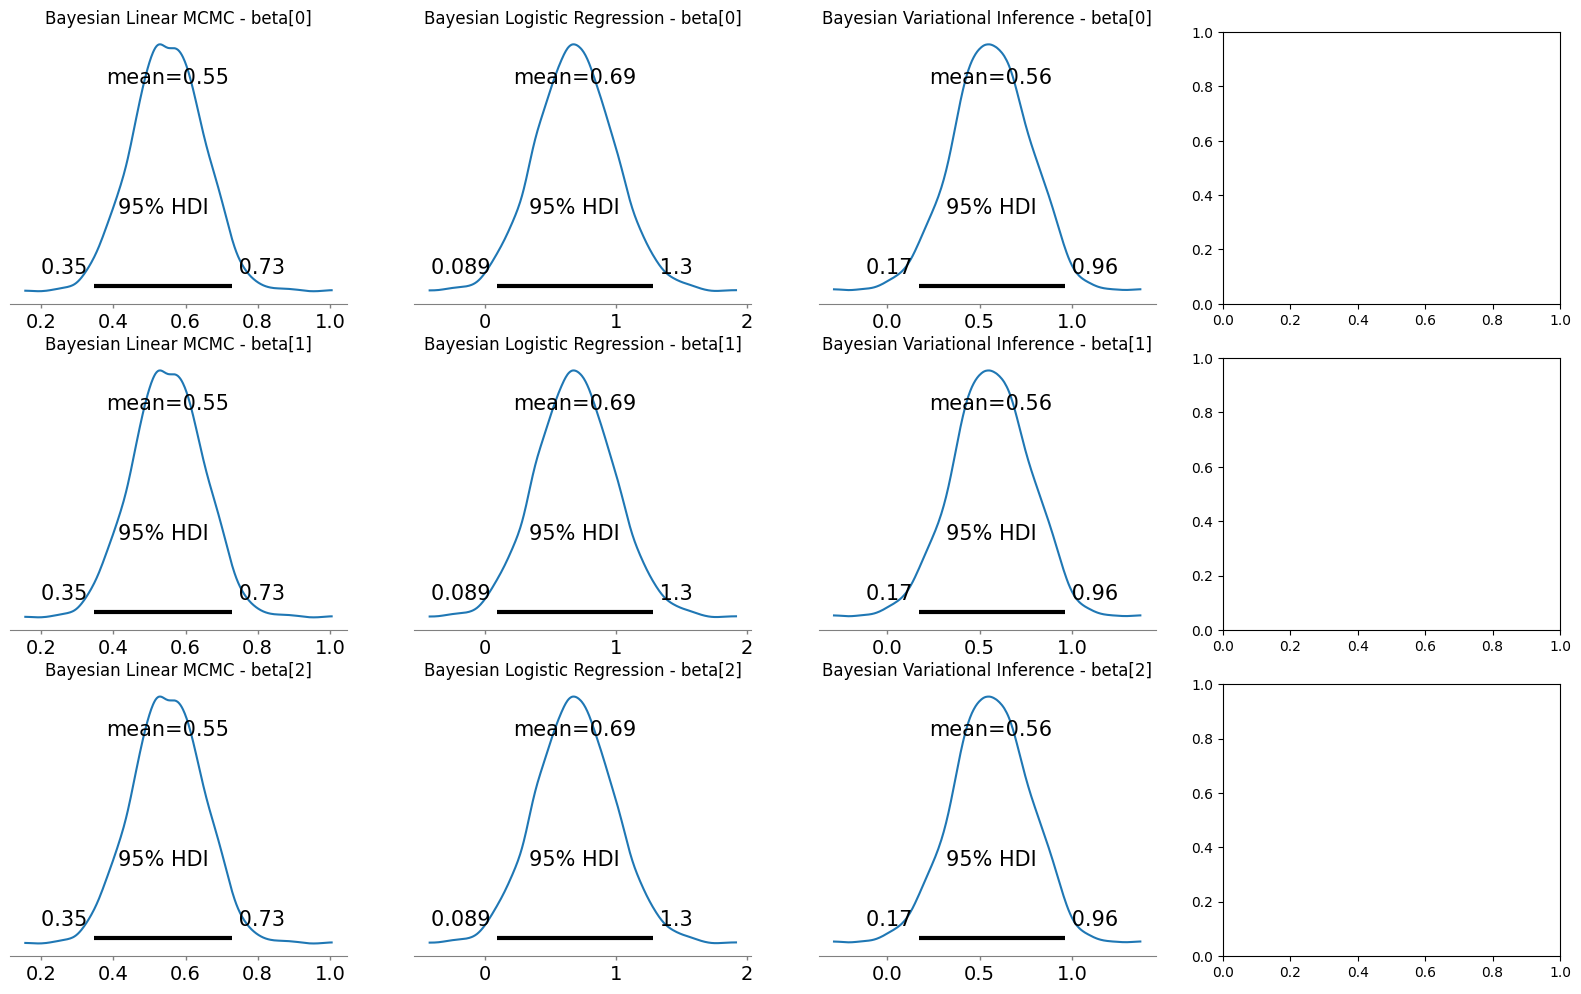

In [6]:
import pymc as pm
import numpy as np
import scipy.stats as stats
import arviz as az
import matplotlib.pyplot as plt
import tensorflow_probability.substrates.numpy as tfp


def bayesian_regression_mcmc(X, y):
    with pm.Model() as model:
        beta = pm.Normal("beta", mu=0, sigma=1, shape=X.shape[1])
        sigma = pm.HalfCauchy("sigma", beta=2)
        mu = pm.math.dot(X, beta)
        y_obs = pm.Normal("y_obs", mu=mu, sigma=sigma, observed=y)
        trace = pm.sample(2000, return_inferencedata=True, target_accept=0.95,
                          idata_kwargs={"log_likelihood": True})
    return model, trace

# Bayesian Logistic Regression
def bayesian_logistic_regression(X, y):
    with pm.Model() as model:
        beta = pm.Normal("beta", mu=0, sigma=1, shape=X.shape[1])
        mu = pm.math.dot(X, beta)
        p = pm.Deterministic("p", pm.math.sigmoid(mu))
        y_obs = pm.Bernoulli("y_obs", p=p, observed=y)
        trace = pm.sample(2000, return_inferencedata=True, target_accept=0.95)
    return model, trace

# Hierarchical Bayesian Model
def hierarchical_bayesian_regression(X, y, group_idx):
    with pm.Model() as model:
        group_means = pm.Normal("group_means", mu=0, sigma=1, shape=np.unique(group_idx).size)
        beta = group_means[group_idx]
        sigma = pm.HalfCauchy("sigma", beta=2)
        mu = pm.math.dot(X, beta)
        y_obs = pm.Normal("y_obs", mu=mu, sigma=sigma, observed=y)
        trace = pm.sample(2000, return_inferencedata=True, target_accept=0.95)
    return model, trace

# Bayesian Variational Inference for Regression
def bayesian_regression_vi(X, y):
    with pm.Model() as model:
        beta = pm.Normal("beta", mu=0, sigma=1, shape=X.shape[1])
        sigma = pm.HalfCauchy("sigma", beta=2)
        mu = pm.math.dot(X, beta)
        y_obs = pm.Normal("y_obs", mu=mu, sigma=sigma, observed=y)
        approx = pm.fit(n=10000, method="advi")
    return model, approx.sample(1000)

# Bayesian Neural Network with Variational Inference
def bayesian_neural_network(X, y):
    with pm.Model() as model:
        weights_in = pm.Normal("weights_in", mu=0, sigma=1, shape=(X.shape[1], 10))
        bias_in = pm.Normal("bias_in", mu=0, sigma=1, shape=10)
        hidden = pm.math.tanh(pm.math.dot(X, weights_in) + bias_in)
        weights_out = pm.Normal("weights_out", mu=0, sigma=1, shape=10)
        bias_out = pm.Normal("bias_out", mu=0, sigma=1)
        mu = pm.math.dot(hidden, weights_out) + bias_out
        sigma = pm.HalfCauchy("sigma", beta=2)
        y_obs = pm.Normal("y_obs", mu=mu, sigma=sigma, observed=y)
        approx = pm.fit(n=10000, method="advi")
    return model, approx.sample(1000)

def compare_mcmc_vs_vi(X, y, group_idx):
    # MCMC
    model_mcmc, trace_mcmc = hierarchical_bayesian_regression(X, y, group_idx)

    # VI
    with pm.Model() as model_vi:
        group_means = pm.Normal("group_means", mu=0, sigma=1, shape=np.unique(group_idx).size)
        beta = group_means[group_idx]
        sigma = pm.HalfCauchy("sigma", beta=2)
        mu = pm.math.dot(X, beta)
        y_obs = pm.Normal("y_obs", mu=mu, sigma=sigma, observed=y)
        approx_vi = pm.fit(n=10000, method="advi")
        trace_vi = approx_vi.sample(1000)

    # Compare Posterior Distributions
    az.plot_posterior(trace_mcmc, var_names=["group_means"], hdi_prob=0.95)
    plt.title("MCMC Posterior Distribution")
    plt.show()

    az.plot_posterior(trace_vi, var_names=["group_means"], hdi_prob=0.95)
    plt.title("VI Posterior Distribution")
    plt.show()

    # Compare Effective Sample Size and Monte Carlo Standard Error
    summary_mcmc = az.summary(trace_mcmc, var_names=["group_means"])
    summary_vi = az.summary(trace_vi, var_names=["group_means"])

    print("MCMC Summary:")
    print(summary_mcmc)
    print("\nVI Summary:")
    print(summary_vi)

    return {
        "MCMC Trace": trace_mcmc,
        "VI Trace": trace_vi,
        "MCMC Summary": summary_mcmc,
        "VI Summary": summary_vi
    }


# Simulated Data Generation
np.random.seed(410)
n = 100
X = np.random.randn(n, 3)
true_beta = np.array([0.5, -1.2, 2.0])
sigma_true = 1
y = np.dot(X, true_beta) + stats.norm(0, sigma_true).rvs(n)
y_binary = (y > np.median(y)).astype(int)  # Binary outcome for logistic regression

# Group indices for hierarchical modeling
group_idx = np.random.randint(0, 5, size=n)

# Model Execution
models_traces = {
    "Bayesian Linear MCMC": bayesian_regression_mcmc(X, y),
    "Bayesian Logistic Regression": bayesian_logistic_regression(X, y_binary),
    #"Hierarchical Bayesian Regression": hierarchical_bayesian_regression(X, y, group_idx),
    "Bayesian Variational Inference": bayesian_regression_vi(X, y),
    "Bayesian Neural Network (VI)": bayesian_neural_network(X, y)
}

# Visualization
fig, axes = plt.subplots(3, 4, figsize=(20, 12))
names = list(models_traces.keys())

for j, (name, (model, trace)) in enumerate(models_traces.items()):
    for i in range(3):
        az.plot_posterior(trace, var_names=["beta"], hdi_prob=0.95, ax=axes[i, j])
        axes[i, j].set_title(f"{name} - beta[{i}]")

plt.suptitle("Posterior Distributions for All Models", fontsize=16)
plt.tight_layout()
plt.subplots_adjust(top=0.85)
plt.show()

# Run comparison
comparison_results = compare_mcmc_vs_vi(X, y, group_idx)


In [10]:
group_idx = np.random.randint(0, 4, size=n)
print(group_idx)
comparison_results = compare_mcmc_vs_vi(X, y, group_idx)


[0 0 3 3 0 1 2 1 0 2 0 0 0 2 2 3 3 2 1 1 3 1 0 0 0 2 2 0 1 2 0 2 0 2 0 2 0
 2 3 0 3 3 2 1 3 0 3 2 2 0 0 1 0 2 1 0 0 3 0 0 1 0 3 2 1 2 2 2 0 0 2 2 2 3
 1 0 0 1 2 2 3 2 1 3 1 0 3 2 3 2 3 2 3 2 0 2 3 1 2 1]


ValueError: Shape mismatch: A.shape[1] != x.shape[0]
Apply node that caused the error: CGemv{no_inplace}(y_obs{[ 1.505368 ... 13571e+00]}, -1.0, [[ 0.30388 ... 10056222]], AdvancedSubtensor1.0, 1.0)
Toposort index: 10
Inputs types: [TensorType(float64, shape=(100,)), TensorType(float64, shape=()), TensorType(float64, shape=(100, 3)), TensorType(float64, shape=(100,)), TensorType(float64, shape=())]
Inputs shapes: [(100,), (), (100, 3), (100,), ()]
Inputs strides: [(8,), (), (24, 8), (8,), ()]
Inputs values: ['not shown', array(-1.), 'not shown', 'not shown', array(1.)]
Outputs clients: [[Composite{...}(CGemv{no_inplace}.0, ExpandDims{axis=0}.0, Log.0, Gt.0)]]

HINT: Re-running with most PyTensor optimizations disabled could provide a back-trace showing when this node was created. This can be done by setting the PyTensor flag 'optimizer=fast_compile'. If that does not work, PyTensor optimizations can be disabled with 'optimizer=None'.
HINT: Use the PyTensor flag `exception_verbosity=high` for a debug print-out and storage map footprint of this Apply node.

In [ ]:
import pymc as pm
import numpy as np
import scipy.stats as stats
import arviz as az
import matplotlib.pyplot as plt

# Bayesian Ridge Regression (Gaussian prior for regularization)
def bayesian_ridge_regression(X, y):
    with pm.Model() as model:
        beta = pm.Normal("beta", mu=0, sigma=1, shape=3)  # Gaussian prior for shrinkage
        sigma = pm.HalfCauchy("sigma", beta=2)
        mu = pm.math.dot(X, beta)
        y_obs = pm.Normal("y_obs", mu=mu, sigma=sigma, observed=y)
        trace = pm.sample(2000, return_inferencedata=True, target_accept=0.95)
    return model, trace

# Bayesian Lasso Regression (Laplace prior for sparsity)
def bayesian_lasso_regression(X, y):
    with pm.Model() as model:
        lambda_ = pm.Exponential("lambda", 1.0)
        beta = pm.Laplace("beta", mu=0, b=lambda_, shape=3)  # Laplace prior for sparsity
        sigma = pm.HalfCauchy("sigma", beta=2)
        mu = pm.math.dot(X, beta)
        y_obs = pm.Normal("y_obs", mu=mu, sigma=sigma, observed=y)
        trace = pm.sample(2000, return_inferencedata=True, target_accept=0.95)
    return model, trace

# Bayesian Horseshoe Regression (Horseshoe prior for sparse models)
def bayesian_horseshoe_regression(X, y):
    with pm.Model() as model:
        tau = pm.HalfCauchy("tau", beta=1)
        lam = pm.HalfCauchy("lam", beta=1, shape=3)
        beta = pm.Normal("beta", mu=0, sigma=tau * lam, shape=3)  # Horseshoe prior
        sigma = pm.HalfCauchy("sigma", beta=2)
        mu = pm.math.dot(X, beta)
        y_obs = pm.Normal("y_obs", mu=mu, sigma=sigma, observed=y)
        trace = pm.sample(2000, return_inferencedata=True, target_accept=0.95)
    return model, trace

# Variational Inference with Regularization (using Normal prior)
def bayesian_vi_regularized(X, y):
    with pm.Model() as model:
        beta = pm.Normal("beta", mu=0, sigma=1, shape=3)  # Regularized VI
        sigma = pm.HalfCauchy("sigma", beta=2)
        mu = pm.math.dot(X, beta)
        y_obs = pm.Normal("y_obs", mu=mu, sigma=sigma, observed=y)
        approx = pm.fit(n=10000, method="advi")
    return model, approx.sample(1000)

# Simulated Data Generation
np.random.seed(410)
n = 50
X = np.ones((n, 3))
for i in range(0, X.shape[1], 2):
    X[i::2, i] = 0
    X[i+1::2, i] = 1
true_beta = np.logspace(0, 1, 3, base=2)
sigma_true = 1
y = np.dot(X, true_beta) + stats.norm(0, sigma_true).rvs(n)

# Model Execution
model_ridge, trace_ridge = bayesian_ridge_regression(X, y)
model_lasso, trace_lasso = bayesian_lasso_regression(X, y)
model_horseshoe, trace_horseshoe = bayesian_horseshoe_regression(X, y)
model_vi, trace_vi = bayesian_vi_regularized(X, y)

# Visualization
fig, axes = plt.subplots(3, 4, figsize=(18, 12))
models = [trace_ridge, trace_lasso, trace_horseshoe, trace_vi]
names = ["Bayesian Ridge", "Bayesian Lasso", "Bayesian Horseshoe", "Bayesian VI"]

for j, trace in enumerate(models):
    for i in range(3):
        az.plot_posterior(trace, var_names=["beta"], hdi_prob=0.95, ax=axes[i, j], rope=(-1, 1))
        axes[i, j].set_title(f"{names[j]} Regression - beta[{i}]")
        axes[i, j].set_xlim(-1, 1)

plt.suptitle("Posterior Distributions with Regularization", fontsize=16)
plt.tight_layout()
plt.subplots_adjust(top=0.85)
plt.show()
